<a href="https://colab.research.google.com/github/hunkim98/earth_science/blob/main/lecture4/EPS210_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Harvard EPS-210 AI for Earth and Planetary Science

Instructor: Mostafa Mouasvi

# **Lab 4**: Multilayer Perceptron

**Activity 1**: Seismic Event Classification using Fully Connected Neural Networks

* Part 1: Setup and Data Loading (~10 minutes)
* Part 2: Building the Neural Network (~15 minutes)
* Part 3: Training the Network (~15 minutes)
* Part 4: Hyperparameter Exploration (~20 minutes)
* Part 5: Challenge Exercises (~10 minutes)

---

## Learning Objectives

By the end of this lab, you will be able to:

1. **Build** a fully-connected neural network for seismic waveform classification
2. **Train** the network using gradient descent and observe the loss landscape
3. **Diagnose** overfitting vs. underfitting using training/validation curves
4. **Apply** regularization techniques (dropout, early stopping) to improve generalization
5. **Tune** hyperparameters (learning rate, batch size, architecture) and understand their effects

---

## The Challenge: Seismic Event Classification

<p align="center">
  <img src="https://github.com/smousavi05/Harvard-EPS-210/raw/main/figures/seismogram_classification.png" width="700">
</p>

As discussed in lecture, we want to classify seismic waveforms into categories:
- **Earthquake** - Tectonic seismic events
- **Noise** - Ambient seismic noise (wind, traffic, ocean waves)
- **Landslide**

This is difficult because:
- Traditional "if/then" programming can't capture the complex patterns
- The signals vary greatly depending on distance, magnitude, and local geology
- We need to learn features directly from raw waveforms

**Our approach:** Use a Multi-Layer Perceptron (MLP) that takes raw waveform samples as input and outputs class probabilities.

## Part 1: Setup and Data Loading (~10 minutes)

First, let's install required packages and load our seismic dataset.

In [ ]:
# Install required packages (run once)
!pip install torch numpy matplotlib scikit-learn seisbench torchview -q
!apt-get install -y graphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 2 not upgraded.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import warnings
import seisbench
import os
import seisbench.data as sbd

warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


### Loading Seismic Data with SeisBench

We'll use [**SeisBench**](https://seisbench.readthedocs.io/en/stable/pages/benchmark_datasets.html), a Python toolbox for machine learning in seismology that provides standardized access to benchmark datasets and models.

For this lab, we'll use a subset of the **Iquique dataset** which contains labeled seismic events.

In [ ]:

# Load Iquique dataset ()
print("Loading seismic dataset from SeisBench...")
print("(This should take a few minutes on first run)")
data = sbd.Iquique(force=True)
print(f"Dataset loaded! Total traces: {len(data)}")

2026-01-27 19:28:19,635 | seisbench | WARNING | Check available storage and memory before downloading and general use of Iquique dataset. Dataset size: waveforms.hdf5 ~5Gb, metadata.csv ~2.6Mb


Loading seismic dataset from SeisBench...
(This should take a few minutes on first run)


2026-01-27 19:28:20,378 | seisbench | WARNING | Dataset Iquique not in cache.
2026-01-27 19:28:20,383 | seisbench | WARNING | Trying to download preprocessed version from SeisBench repository.
2026-01-27 19:31:47,207 | seisbench | WARNING | Output component order not specified, defaulting to 'ZNE'.


Dataset loaded! Total traces: 13400


Taking a look at the downloaded data.

In [ ]:
import seisbench
import os

# All downloaded data is stored in the SeisBench cache. The location of the cache defaults
# to ~/.seisbench, but can be set using the environment variable SEISBENCH_CACHE_ROOT.
# Let's inspect the cache. Depending which commands where used before, it contains at
# least the directory datasets. Inside this directory, each locally available dataset
# has its own folder. If we look into the folder iquique, we find two relevant files
# metadata.csv and waveforms.hdf5, containing the metadata and the waveforms.

print("Cache root:", seisbench.cache_root)
print("Contents:", os.listdir(seisbench.cache_root))
print("datasets:", os.listdir(seisbench.cache_root / "datasets"))
print("dummydataset:", os.listdir(seisbench.cache_root / "datasets" / "iquique"))

Cache root: /root/.seisbench
Contents: ['config.json', 'datasets']
datasets: ['iquique']
dummydataset: ['metadata.csv', 'waveforms.hdf5']


Each dataset consists of waveforms and the associated metadata. Let's first inspect the metadata. It is represented by a pandas DataFrame and lists for each trace different attributes, describing properties of the source, the trace, the station and possibly the path. When loading a dataset, only the metadata is loaded into memory. The waveforms are loaded on demand.

2026-01-27 19:31:47,340 | seisbench | WARNING | Output component order not specified, defaulting to 'ZNE'.


Index(['index', 'source_origin_time', 'source_latitude_deg',
       'source_longitude_deg', 'source_depth_km', 'path_back_azimuth_deg',
       'station_network_code', 'station_code', 'trace_channel',
       'station_location_code', 'station_latitude_deg',
       'station_longitude_deg', 'station_elevation_m', 'trace_name',
       'trace_sampling_rate_hz', 'trace_completeness', 'trace_has_spikes',
       'trace_start_time', 'trace_P_arrival_sample', 'trace_S_arrival_sample',
       'trace_name_original', 'trace_chunk', 'trace_component_order', 'split'],
      dtype='object')
       index           source_origin_time  source_latitude_deg  \
0          0  2014-05-01T00:52:20.970000Z             -19.4527   
1          1  2014-05-01T00:52:20.970000Z             -19.4527   
2          2  2014-05-01T00:52:20.970000Z             -19.4527   
3          3  2014-05-01T00:52:20.970000Z             -19.4527   
4          4  2014-05-01T00:52:20.970000Z             -19.4527   
...      ...           

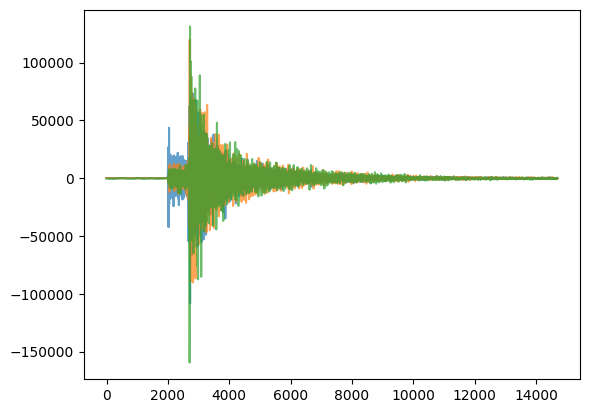

In [ ]:
import matplotlib.pyplot as plt
data = sbd.WaveformDataset(
    seisbench.cache_root / "datasets" / "iquique"
)
print(data.metadata.keys())
print(data.metadata)

waveforms = data.get_waveforms(3)
print("waveforms.shape:", waveforms.shape)

plt.plot(waveforms.T, alpha=0.7);
plt.show()

We use a portion of this earthquake waveforms and create a similar number of synthetic noise and landslide waveforms.

In [ ]:
n_sample = 14000
import numpy as np

def generate_synthetic_seismic_data(n_samples=1000, n_timesteps=1000):
    """
    Generates synthetic 'Landslide' waveforms.
    Landslides are emergent, long-duration, chaotic signals with a 'spindle' shape.
    """
    X = np.zeros((n_samples, n_timesteps))
    y = np.zeros(n_samples, dtype=int)

    # Time vector (20 seconds duration)
    t = np.linspace(0, 20, n_timesteps).reshape(1, -1)

    # ---------------------------------------------------------
    # CLASS 1: Background Noise
    # ---------------------------------------------------------
    half = n_samples // 2
    # Low amplitude background hum
    noise_background = np.random.normal(0, 0.1, (n_samples, n_timesteps))
    X[:half] = noise_background[:half]
    y[:half] = 1  # Label 1 for Noise

    # ---------------------------------------------------------
    # CLASS 2: Landslides
    # ---------------------------------------------------------
    n_land = n_samples - half

    # 1. Random Centers (Time when the landslide is loudest)
    centers = np.random.uniform(5.0, 15.0, (n_land, 1))

    # 2. Random Durations (Width of the event)
    widths = np.random.uniform(1.0, 2.5, (n_land, 1))

    # 3. Create the Envelope (The "Spindle" Shape)
    # Gaussian bell curve: rises slowly, peaks, decays slowly
    dt = t - centers
    envelope = np.exp(-0.5 * (dt / widths)**2)

    # 4. Carrier Signal (The "Rumble")
    # Landslides are chaotic (rocks hitting rocks).
    carrier = np.random.normal(0, 1, (n_land, n_timesteps))

    # 5. Amplitude Variation
    amps = np.random.uniform(2.0, 5.0, (n_land, 1))

    # Combine: Envelope * Chaos + Background Noise
    # Note: We broadcast (n_land, 1) * (n_land, 1000)
    signal = (envelope * amps) * carrier

    X[half:] = signal + noise_background[half:]
    y[half:] = 2  # Label 2 for Landslide

    return X, y

# Map source types to class labels
class_map = {'earthquake': 0, 'noise': 1, 'landslides': 2}

# Initialize lists to collect earthquake data
earthquake_X_list = []
earthquake_y_list = []
earthquake_count = 0

# Collect earthquake examples from the downloaded dataset
print(f"Collecting {n_sample} earthquake samples...")
# Iterate over the full dataset `data` to find actual earthquake events
for i in range(len(data)):
  if earthquake_count >= n_sample:
    break # Stop once we have collected n_sample earthquakes

  metadata = data.metadata.iloc[i]
  # Default to 'earthquake' if source_type is not available in metadata
  source_type = str(metadata.get('source_type', 'earthquake')).lower()

  if source_type == 'earthquake':
    waveform = data.get_waveforms(i)
    # Use vertical component (index 2) or index 0 if 1-channel
    # Assuming waveforms are always 3 channels or 1 channel
    trace = waveform[2] if waveform.shape[0] == 3 else waveform[0]

    # --- Fast Resampling ---
    current_len = len(trace)
    if current_len == 1000:
      final_trace = trace
    elif current_len > 1000:
      # Downsampling
      indices = np.linspace(0, current_len - 1, 1000, dtype=int)
      final_trace = trace[indices]
    else:
      # Padding
      pad_width = 1000 - current_len
      final_trace = np.pad(trace, (0, pad_width), mode='constant')

    earthquake_X_list.append(final_trace)
    earthquake_y_list.append(class_map[source_type])
    earthquake_count += 1

print(f"Finished collecting {earthquake_count} earthquake samples.")

# Convert collected earthquake data lists to numpy arrays
X_earthquake = np.array(earthquake_X_list, dtype=np.float32)
y_earthquake = np.array(earthquake_y_list, dtype=int)

# Generate synthetic noise and landslide data
print(f"Generating {n_sample} noise and {n_sample} landslides samples...")
# The generate_synthetic_seismic_data function with n_samples=2*n_sample
# will produce n_sample noise (Class 1) and n_sample landslide (Class 2).
X_synth, y_synth = generate_synthetic_seismic_data(2 * n_sample, 1000)
print("Finished generating synthetic samples.")

# Combine all data using np.concatenate
X = np.concatenate((X_earthquake, X_synth), axis=0)
y = np.concatenate((y_earthquake, y_synth), axis=0)

# Normalize the data (critical for neural networks!)
X = (X - X.mean(axis=1, keepdims=True)) / (X.std(axis=1, keepdims=True) + 1e-8)

print(f"\nData shape: {X.shape}")
print(f"Class distribution: {np.bincount(y)}")
print(f"Classes: 0=Earthquake, 1=Noise, 2=Landslide")

Finished collecting 13400 earthquake samples.
Generating 14000 noise and 14000 landslides samples...
Finished generating synthetic samples.

Data shape: (41400, 1000)
Class distribution: [13400 14000 14000]
Classes: 0=Earthquake, 1=Noise, 2=Landslide


### Visualize Sample Waveforms

Let's look at examples from each class to understand what our network needs to learn.

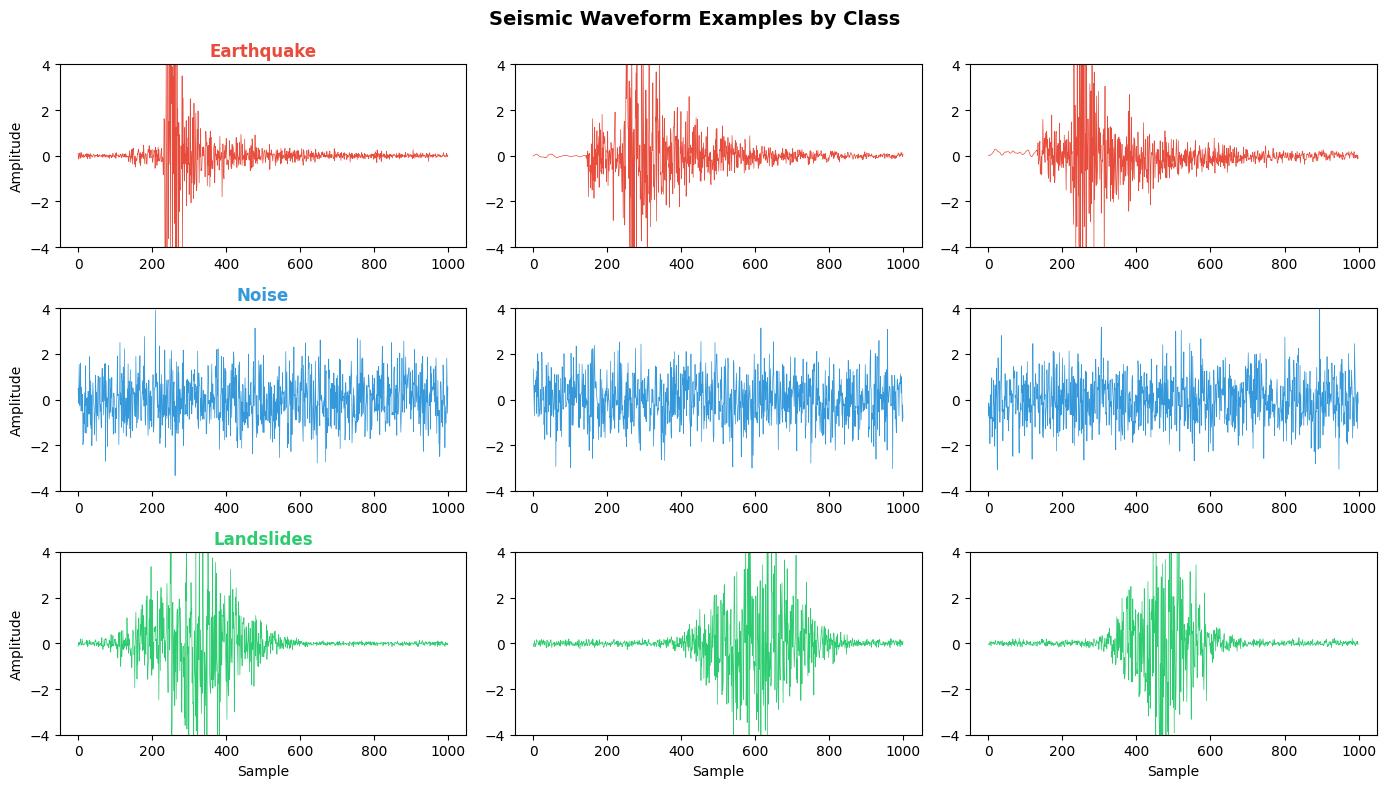

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(14, 8))
class_names = ['Earthquake', 'Noise', 'Landslides']
colors = ['#e74c3c', '#3498db', '#2ecc71']

for row, (class_idx, class_name) in enumerate(zip([0, 1, 2], class_names)):
    samples = np.where(y == class_idx)[0][:3]
    for col, idx in enumerate(samples):
        axes[row, col].plot(X[idx], color=colors[class_idx], linewidth=0.5)
        axes[row, col].set_ylabel('Amplitude' if col == 0 else '')
        axes[row, col].set_xlabel('Sample' if row == 2 else '')
        if col == 0:
            axes[row, col].set_title(f'{class_name}', fontsize=12, fontweight='bold', color=colors[class_idx])
        axes[row, col].set_ylim(-4, 4)

plt.suptitle('Seismic Waveform Examples by Class', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Prepare Data for Training

Split into training, validation, and test sets using stratified sampling to maintain class balance.

In [ ]:
# Split data: 70% train, 15% validation, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

# Convert to PyTorch tensors
X_train_t = torch.FloatTensor(X_train).to(device)
y_train_t = torch.LongTensor(y_train).to(device)
X_val_t = torch.FloatTensor(X_val).to(device)
y_val_t = torch.LongTensor(y_val).to(device)
X_test_t = torch.FloatTensor(X_test).to(device)
y_test_t = torch.LongTensor(y_test).to(device)

# Create DataLoaders
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)

Training samples: 28980
Validation samples: 6210
Test samples: 6210


---

## Part 2: Building the Neural Network (~15 minutes)

### Architecture from Lecture

Recall from the lecture slides, our network architecture is:

```
Input (1000) → Hidden (16) → Hidden (16) → Hidden (10) → Output (3)
```

This gives us: `(1000×16)+16 + (16×16)+16 + (16×10)+10 + (10×3)+3 = 16,491 parameters`

In [ ]:
class SeismicClassifier(nn.Module):
    """
    Multi-Layer Perceptron for seismic event classification.

    Architecture matches lecture slides:
    Input (1000) -> 16 -> 16 -> 10 -> Output (3)
    """

    def __init__(self, input_size=1000, hidden_sizes=[16, 16, 10],
                 num_classes=3, dropout_rate=0.0):
        super(SeismicClassifier, self).__init__()

        layers = []
        prev_size = input_size

        # Build hidden layers
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())  # adding the activation function
            if dropout_rate > 0:
                layers.append(nn.Dropout(dropout_rate))
            prev_size = hidden_size

        # Output layer (no activation - CrossEntropyLoss includes softmax)
        layers.append(nn.Linear(prev_size, num_classes))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Create the model
model = SeismicClassifier(
    input_size=1000,
    hidden_sizes=[16, 16, 10],
    num_classes=3,
    dropout_rate=0.0
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Model Architecture:")
print(model)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Model Architecture:
SeismicClassifier(
  (network): Sequential(
    (0): Linear(in_features=1000, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=3, bias=True)
  )
)

Total parameters: 16,491
Trainable parameters: 16,491


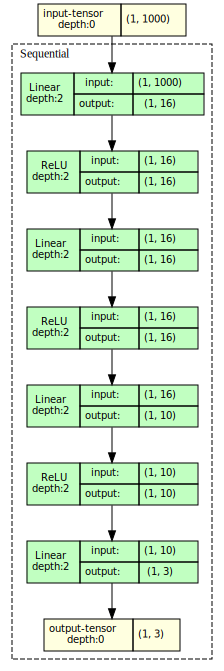

In [ ]:
# pip install torchview
from torchview import draw_graph

model_graph = draw_graph(
    model,
    input_size=(1, 1000),
    expand_nested=True,
    graph_name='SeismicClassifier',
    directory='.'
)

model_graph.visual_graph

### ❓ Question 1

**Verify the parameter count calculation from the lecture:**

For each layer, parameters = (input_size × output_size) + output_size (for biases)

Calculate:
- Layer 1: (1000 × 16) + 16 = ?
- Layer 2: (16 × 16) + 16 = ?
- Layer 3: (16 × 10) + 10 = ?
- Layer 4: (10 × 3) + 3 = ?
- Total = ?

**Does it match the model output above?**

In [ ]:
# Your calculation here:
layer1 = (1000 * 16) + 16
layer2 = (16 * 16) + 16
layer3 = (16 * 10) + 10
layer4 = (10 * 3) + 3
total = layer1 + layer2 + layer3 + layer4

print(f"Layer 1: {layer1}")
print(f"Layer 2: {layer2}")
print(f"Layer 3: {layer3}")
print(f"Layer 4: {layer4}")
print(f"Total: {total}")

Layer 1: 16016
Layer 2: 272
Layer 3: 170
Layer 4: 33
Total: 16491


---

## Part 3: Training the Network (~15 minutes)

### Setting Up the Training Loop

As covered in lecture, training involves:
1. **Forward Pass**: Compute predictions
2. **Calculate Loss**: Measure error using Cross-Entropy
3. **Backward Pass**: Compute gradients via backpropagation
4. **Update Weights**: Apply gradient descent

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer,
                num_epochs=100, patience=10, verbose=True):
    """
    Train the neural network with early stopping.

    Returns:
        history: dict with training/validation loss and accuracy
    """
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': []
    }

    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for X_batch, y_batch in train_loader:
            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * X_batch.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_total += y_batch.size(0)
            train_correct += (predicted == y_batch).sum().item()

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

                val_loss += loss.item() * X_batch.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_total += y_batch.size(0)
                val_correct += (predicted == y_batch).sum().item()

        # Calculate metrics
        train_loss /= train_total
        val_loss /= val_total
        train_acc = train_correct / train_total
        val_acc = val_correct / val_total

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1

        if verbose and (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if patience_counter >= patience:
            if verbose:
                print(f"\nEarly stopping at epoch {epoch+1}")
            break

    # Restore best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return history

### Train the Baseline Model

In [ ]:
# Hyperparameters
LEARNING_RATE = 0.001
BATCH_SIZE = 32
NUM_EPOCHS = 100

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Includes softmax
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("Training baseline model...")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Max Epochs: {NUM_EPOCHS}")
print("-" * 60)

history = train_model(
    model, train_loader, val_loader,
    criterion, optimizer,
    num_epochs=NUM_EPOCHS,
    patience=30
)

Training baseline model...
Learning Rate: 0.001
Batch Size: 32
Max Epochs: 100
------------------------------------------------------------
Epoch [10/100] Train Loss: 0.1149, Train Acc: 0.9551 | Val Loss: 0.6041, Val Acc: 0.8424
Epoch [20/100] Train Loss: 0.0541, Train Acc: 0.9801 | Val Loss: 0.9497, Val Acc: 0.8359
Epoch [30/100] Train Loss: 0.0396, Train Acc: 0.9860 | Val Loss: 1.1460, Val Acc: 0.8407

Early stopping at epoch 33


### Visualize Training Progress

The training curves help us diagnose overfitting vs underfitting.

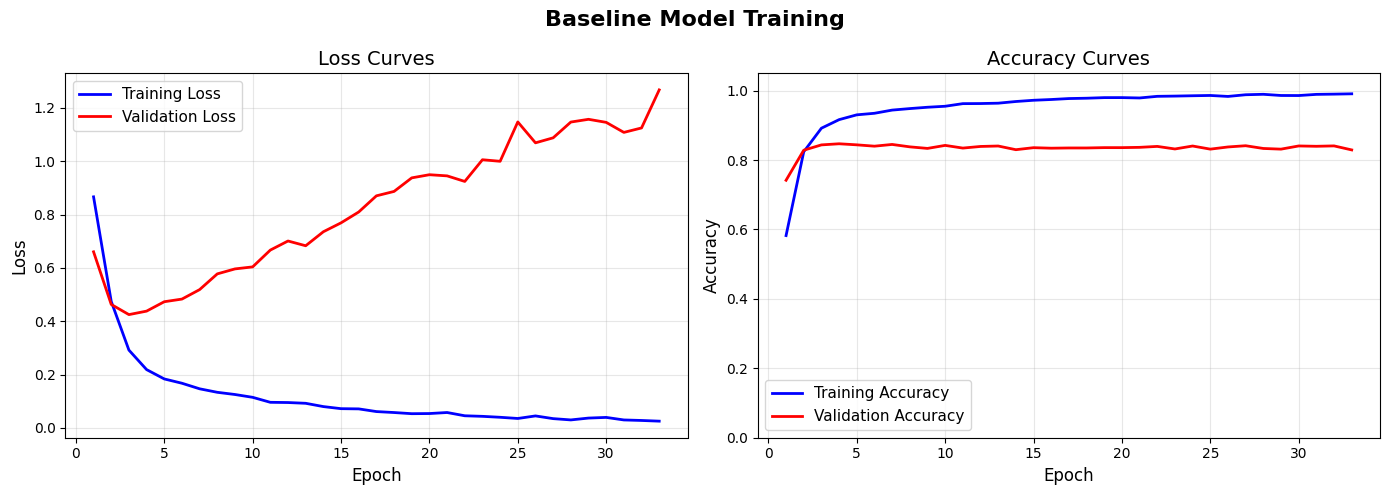

In [ ]:
def plot_training_history(history, title="Training History"):
    """Plot training and validation loss/accuracy curves."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    epochs = range(1, len(history['train_loss']) + 1)

    # Loss plot
    ax1.plot(epochs, history['train_loss'], 'b-', label='Training Loss', linewidth=2)
    ax1.plot(epochs, history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Loss Curves', fontsize=14)
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)

    # Accuracy plot
    ax2.plot(epochs, history['train_acc'], 'b-', label='Training Accuracy', linewidth=2)
    ax2.plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy', linewidth=2)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.set_title('Accuracy Curves', fontsize=14)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 1.05)

    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

plot_training_history(history, "Baseline Model Training")

### ❓ Question 2

Look at the training curves above:

1. **Is the model overfitting, underfitting, or well-fit?**
2. **What happens to the gap between training and validation accuracy over epochs?**

### Evaluate on Test Set

Test Accuracy: 0.8293 (82.9%)

Classification Report:
              precision    recall  f1-score   support

  Earthquake       0.77      0.82      0.80      2010
       Noise       0.93      0.82      0.87      2100
  Landslides       0.80      0.85      0.82      2100

    accuracy                           0.83      6210
   macro avg       0.83      0.83      0.83      6210
weighted avg       0.83      0.83      0.83      6210



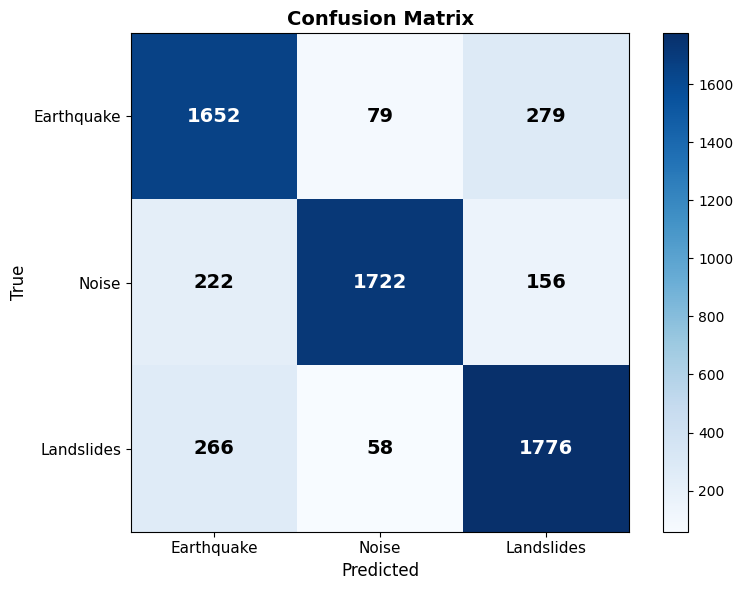

In [ ]:
def evaluate_model(model, X_test, y_test, class_names):
    """Evaluate model and show confusion matrix."""
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        _, predictions = torch.max(outputs, 1)

    y_pred = predictions.cpu().numpy()
    y_true = y_test.cpu().numpy()

    # Accuracy
    accuracy = (y_pred == y_true).mean()
    print(f"Test Accuracy: {accuracy:.4f} ({accuracy*100:.1f}%)")

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names, labels=[0, 1, 2], zero_division=0))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])

    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(cm, cmap='Blues')

    ax.set_xticks(range(len(class_names)))
    ax.set_yticks(range(len(class_names)))
    ax.set_xticklabels(class_names, fontsize=11)
    ax.set_yticklabels(class_names, fontsize=11)
    ax.set_xlabel('Predicted', fontsize=12)
    ax.set_ylabel('True', fontsize=12)
    ax.set_title('Confusion Matrix', fontsize=14, fontweight='bold')

    # Add text annotations
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            color = 'white' if cm[i, j] > cm.max()/2 else 'black'
            ax.text(j, i, str(cm[i, j]), ha='center', va='center',
                   color=color, fontsize=14, fontweight='bold')

    plt.colorbar(im)
    plt.tight_layout()
    plt.show()

    return accuracy

class_names = ['Earthquake', 'Noise', 'Landslides']
baseline_accuracy = evaluate_model(model, X_test_t, y_test_t, class_names)

---

## Part 4: Hyperparameter Exploration (~20 minutes)

Now let's explore how different hyperparameters affect training.

### Learning Rate Comparison

As shown in the lecture, learning rate is critical:
- **Too small**: Slow convergence
- **Too large**: Overshoots, unstable training
- **Just right**: Smooth convergence

In [ ]:
learning_rates = [0.1, 0.01, 0.001, 0.0001]
lr_histories = {}

print("Comparing different learning rates...\n")

for lr in learning_rates:
    print(f"Training with LR = {lr}")

    # Fresh model for each experiment
    model_lr = SeismicClassifier(
        input_size=1000,
        hidden_sizes=[16, 16, 10],
        num_classes=3
    ).to(device)

    optimizer_lr = optim.Adam(model_lr.parameters(), lr=lr)

    lr_histories[lr] = train_model(
        model_lr, train_loader, val_loader,
        criterion, optimizer_lr,
        num_epochs=50, patience=50, verbose=False
    )

    final_val_acc = lr_histories[lr]['val_acc'][-1]
    print(f"  Final validation accuracy: {final_val_acc:.4f}\n")

Comparing different learning rates...

Training with LR = 0.1
  Final validation accuracy: 0.3237

Training with LR = 0.01
  Final validation accuracy: 0.8338

Training with LR = 0.001
  Final validation accuracy: 0.8404

Training with LR = 0.0001
  Final validation accuracy: 0.7866



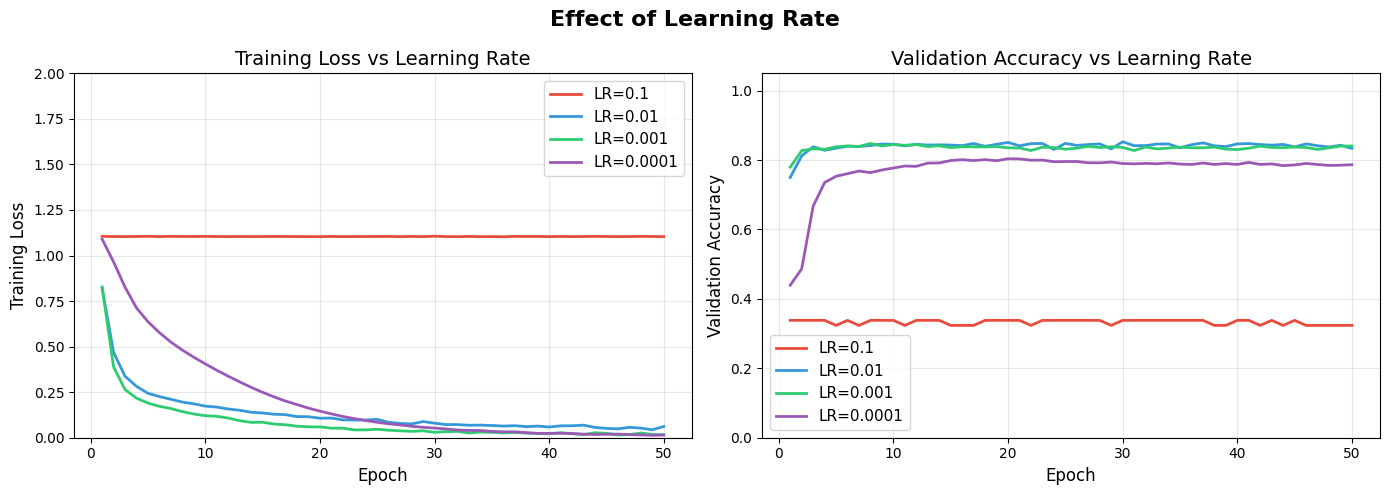

In [ ]:
# Plot learning rate comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

colors = ['#e74c3c', '#3498db', '#2ecc71', '#9b59b6']

for i, (lr, hist) in enumerate(lr_histories.items()):
    epochs = range(1, len(hist['train_loss']) + 1)
    ax1.plot(epochs, hist['train_loss'], color=colors[i],
             linestyle='-', label=f'LR={lr}', linewidth=2)
    ax2.plot(epochs, hist['val_acc'], color=colors[i],
             linestyle='-', label=f'LR={lr}', linewidth=2)

ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Training Loss', fontsize=12)
ax1.set_title('Training Loss vs Learning Rate', fontsize=14)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 2)

ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Validation Accuracy', fontsize=12)
ax2.set_title('Validation Accuracy vs Learning Rate', fontsize=14)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 1.05)

plt.suptitle('Effect of Learning Rate', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### ❓ Question 3

Based on the plots above:

1. **Which learning rate converges fastest?**
2. **Which learning rate gives the best final validation accuracy?**
3. **What happens with LR=0.1? Why?**

### Effect of Dropout (Regularization)

Dropout randomly "turns off" neurons during training to prevent co-adaptation and overfitting.

In [ ]:
dropout_rates = [0.0, 0.2, 0.5]
dropout_histories = {}

print("Comparing different dropout rates...\n")

for dropout in dropout_rates:
    print(f"Training with Dropout = {dropout}")

    model_drop = SeismicClassifier(
        input_size=1000,
        hidden_sizes=[16, 16, 10],
        num_classes=3,
        dropout_rate=dropout
    ).to(device)

    optimizer_drop = optim.Adam(model_drop.parameters(), lr=0.001)

    dropout_histories[dropout] = train_model(
        model_drop, train_loader, val_loader,
        criterion, optimizer_drop,
        num_epochs=80, patience=80, verbose=False
    )

    final_train_acc = dropout_histories[dropout]['train_acc'][-1]
    final_val_acc = dropout_histories[dropout]['val_acc'][-1]
    gap = final_train_acc - final_val_acc
    print(f"  Train Acc: {final_train_acc:.4f}, Val Acc: {final_val_acc:.4f}, Gap: {gap:.4f}\n")

Comparing different dropout rates...

Training with Dropout = 0.0
  Train Acc: 0.9981, Val Acc: 0.8338, Gap: 0.1643

Training with Dropout = 0.2
  Train Acc: 0.9332, Val Acc: 0.8767, Gap: 0.0565

Training with Dropout = 0.5
  Train Acc: 0.7213, Val Acc: 0.7675, Gap: -0.0461



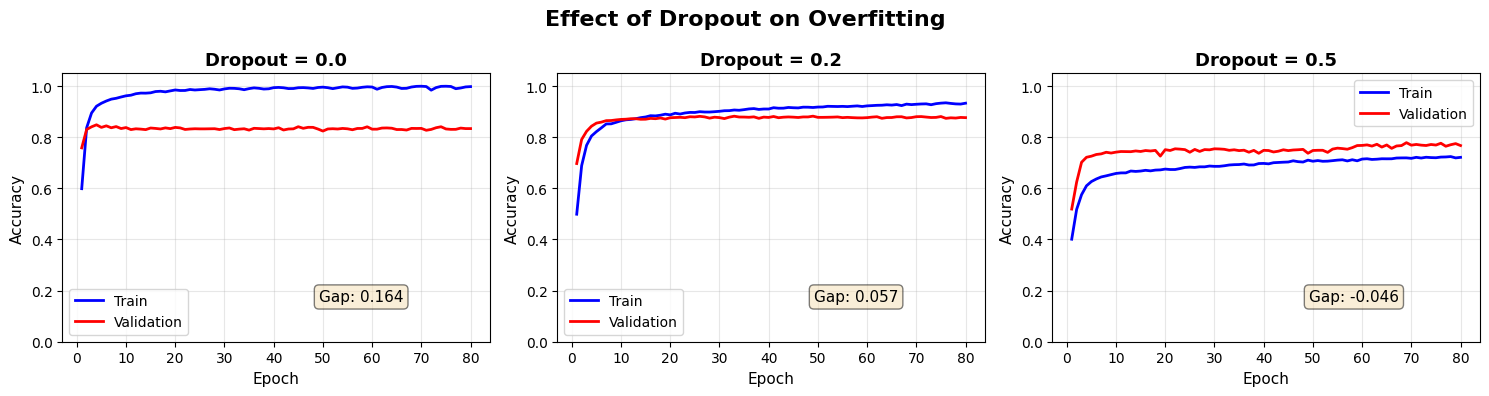

In [ ]:
# Plot dropout comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, (dropout, hist) in enumerate(dropout_histories.items()):
    epochs = range(1, len(hist['train_acc']) + 1)
    axes[i].plot(epochs, hist['train_acc'], 'b-', label='Train', linewidth=2)
    axes[i].plot(epochs, hist['val_acc'], 'r-', label='Validation', linewidth=2)
    axes[i].set_xlabel('Epoch', fontsize=11)
    axes[i].set_ylabel('Accuracy', fontsize=11)
    axes[i].set_title(f'Dropout = {dropout}', fontsize=13, fontweight='bold')
    axes[i].legend(fontsize=10)
    axes[i].grid(True, alpha=0.3)
    axes[i].set_ylim(0, 1.05)

    # Annotate the gap
    gap = hist['train_acc'][-1] - hist['val_acc'][-1]
    axes[i].annotate(f'Gap: {gap:.3f}', xy=(0.6, 0.15), xycoords='axes fraction',
                    fontsize=11, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('Effect of Dropout on Overfitting', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### ❓ Question 4

1. **How does dropout affect the gap between training and validation accuracy?**
2. **Is there a tradeoff? What happens to training accuracy with more dropout?**
3. **Which dropout rate would you choose for this problem?**

### Effect of Architecture (Width and Depth)

Let's compare different network architectures.

In [ ]:
architectures = {
    'Tiny (8-8)': [8, 8],
    'Lecture (16-16-10)': [16, 16, 10],
    'Wide (64-64)': [64, 64],
    'Deep (32-32-32-32)': [32, 32, 32, 32],
}

arch_results = {}

print("Comparing different architectures...\n")

for name, hidden_sizes in architectures.items():
    print(f"Training {name}...")

    model_arch = SeismicClassifier(
        input_size=1000,
        hidden_sizes=hidden_sizes,
        num_classes=3,
        dropout_rate=0.2
    ).to(device)

    n_params = sum(p.numel() for p in model_arch.parameters())

    optimizer_arch = optim.Adam(model_arch.parameters(), lr=0.001)

    hist = train_model(
        model_arch, train_loader, val_loader,
        criterion, optimizer_arch,
        num_epochs=60, patience=60, verbose=False
    )

    # Evaluate on test set
    model_arch.eval()
    with torch.no_grad():
        outputs = model_arch(X_test_t)
        _, predictions = torch.max(outputs, 1)
    test_acc = (predictions == y_test_t).float().mean().item()

    arch_results[name] = {
        'params': n_params,
        'test_acc': test_acc,
        'history': hist
    }

    print(f"  Parameters: {n_params:,}, Test Accuracy: {test_acc:.4f}\n")

Comparing different architectures...

Training Tiny (8-8)...
  Parameters: 8,107, Test Accuracy: 0.8432

Training Lecture (16-16-10)...
  Parameters: 16,491, Test Accuracy: 0.8568

Training Wide (64-64)...
  Parameters: 68,419, Test Accuracy: 0.9134

Training Deep (32-32-32-32)...
  Parameters: 35,299, Test Accuracy: 0.8976



In [ ]:
# Summarize architecture comparison
print("\n" + "="*60)
print("Architecture Comparison Summary")
print("="*60)
print(f"{'Architecture':<25} {'Parameters':>12} {'Test Acc':>12}")
print("-"*60)
for name, results in arch_results.items():
    print(f"{name:<25} {results['params']:>12,} {results['test_acc']:>12.4f}")


Architecture Comparison Summary
Architecture                Parameters     Test Acc
------------------------------------------------------------
Tiny (8-8)                       8,107       0.8432
Lecture (16-16-10)              16,491       0.8568
Wide (64-64)                    68,419       0.9134
Deep (32-32-32-32)              35,299       0.8976


---

## Part 5: Challenge Exercises (~10 minutes)

### Exercise 1: Beat the Baseline

Try to achieve higher accuracy than the baseline by modifying:
- Learning rate
- Architecture (layer sizes)
- Dropout rate
- Optimizer (try SGD with momentum)

Training your best model...
Epoch [10/100] Train Loss: 0.2232, Train Acc: 0.9215 | Val Loss: 0.3043, Val Acc: 0.8973
Epoch [20/100] Train Loss: 0.1512, Train Acc: 0.9482 | Val Loss: 0.3201, Val Acc: 0.9029
Epoch [30/100] Train Loss: 0.1256, Train Acc: 0.9588 | Val Loss: 0.3635, Val Acc: 0.9127

Early stopping at epoch 31

Final Evaluation:
Test Accuracy: 0.9074 (90.7%)

Classification Report:
              precision    recall  f1-score   support

  Earthquake       0.89      0.84      0.87      2010
       Noise       0.94      0.99      0.97      2100
  Landslides       0.88      0.89      0.88      2100

    accuracy                           0.91      6210
   macro avg       0.91      0.91      0.91      6210
weighted avg       0.91      0.91      0.91      6210



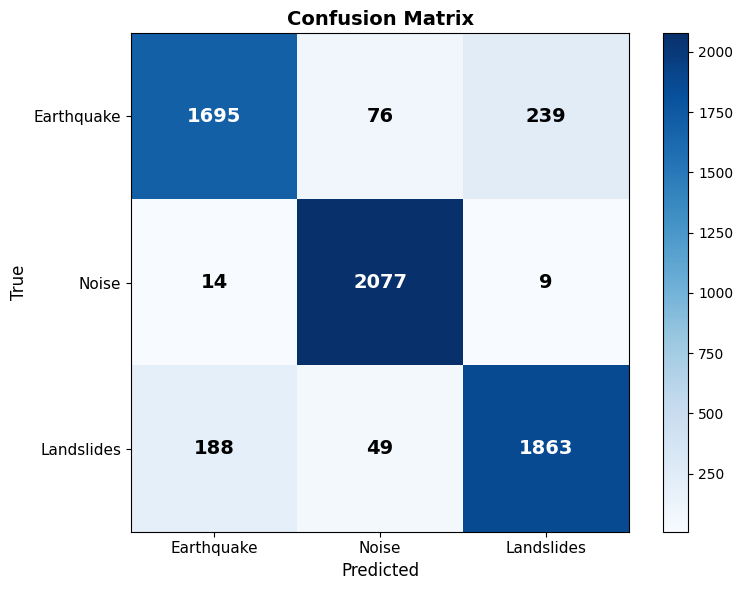


Baseline Accuracy: 0.8293
Your Accuracy: 0.9074
🎉 Congratulations! You beat the baseline!


In [ ]:
# YOUR CODE HERE: Create your best model

best_model = SeismicClassifier(
    input_size=1000,
    hidden_sizes=[64, 32, 16],  # Try different sizes
    num_classes=3,
    dropout_rate=0.3  # Try different dropout
).to(device)

# Try different optimizers
best_optimizer = optim.Adam(best_model.parameters(), lr=0.001, weight_decay=1e-4)
# Alternative: optim.SGD(best_model.parameters(), lr=0.01, momentum=0.9)

print("Training your best model...")
best_history = train_model(
    best_model, train_loader, val_loader,
    criterion, best_optimizer,
    num_epochs=100, patience=15
)

print("\nFinal Evaluation:")
your_accuracy = evaluate_model(best_model, X_test_t, y_test_t, class_names)

print(f"\nBaseline Accuracy: {baseline_accuracy:.4f}")
print(f"Your Accuracy: {your_accuracy:.4f}")
if your_accuracy > baseline_accuracy:
    print("🎉 Congratulations! You beat the baseline!")
else:
    print("Keep experimenting with hyperparameters!")

### Exercise 2: Visualize What the Network Learns

Let's look at the weights of the first layer to understand what features the network is detecting.

In [ ]:
# Hint: this is how we can get the learned weights of first layer:
first_layer_weights = model.network[0].weight.data.cpu().numpy()
print(f"First layer weight shape: {first_layer_weights.shape}")

# Compelet the rest ...

NameError: name 'model' is not defined

---

## Summary & Key Takeaways

### What We Learned:

1. **Neural Network Architecture**
   - Input layer size matches data dimensions (1000 samples)
   - Hidden layers extract hierarchical features
   - Output layer has one neuron per class

2. **Training Process**
   - Forward pass computes predictions
   - Loss measures prediction error
   - Backpropagation computes gradients
   - Optimizer updates weights

3. **Hyperparameter Effects**
   - Learning rate: Too high → instability, too low → slow convergence
   - Dropout: Reduces overfitting gap, may slow training
   - Architecture: More parameters ≠ better performance

4. **Regularization is Essential**
   - Early stopping prevents memorization
   - Dropout forces redundant representations
   - Monitor validation loss, not just training loss


## 🏆 Going Further: Real-World Competitions & Data

If you enjoyed this lab, these resources offer "next-level" challenges using the same skills:

1. [**Near-Earth Objects (NEO) Classification**](https://github.com/doguilmak/Nearest-Earth-Objects-Classification/blob/main/NASA_NEOs_ANN_Classification.ipynb)

The Challenge: NEOs could potentially hit our planet and, depending on their size, produce considerable damage. While the chance of a large object hitting Earth is very small, it would produce a great deal of destruction. NEOs thus merit active detection and tracking efforts.

Task: Build a classification model to classify whether NEOs are dangerous or not, through data obtained from NASA.
